# Gaussian Mixture Models
---
#### by Vince Petaccio

In this notebook, I'll be exploring Gaussian Mixture Models and applying the technique to identifying three clusters of data from [this](https://archive.ics.uci.edu/ml/datasets/seeds#) data set containing the physical characteristics of Kama, Rosa, and Canadian wheat seeds.

Let's start by importing some libraries. We'll use NumPy for linear algebra and matrix manipulation, Pandas for loading in our dataset, scikit-learn for the mixture model, and matplotlib for our visualization.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn import mixture
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Set the default plot figure size
plt.rcParams['figure.figsize'] = [15, 10]
# Set a random seed
np.random.seed(27)

Now, let's import our dataset. We'll give the columns names corresponding to the features they represent.

In [3]:
seed_data = pd.read_csv('seeds_dataset.txt', sep='\t', header=None, names=['area','perimeter','compactness','length',
                                                                          'width','asym_coeff','groove_len','label'])
seed_data.head(10)

,area,perimeter,compactness,length,width,asym_coeff,groove_len,label
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1
5,14.38,14.21,0.8951,5.386,3.312,2.462,4.956,1
6,14.69,14.49,0.8799,5.563,3.259,3.586,5.219,1
7,14.11,14.10,0.8911,5.420,3.302,2.700,5.000,1
8,16.63,15.46,0.8747,6.053,3.465,2.040,5.877,1
9,16.44,15.25,0.8880,5.884,3.505,1.969,5.533,1


In order to actually test out our model later, let's set aside some of the data points as test data. We **don't want to touch this data until we're done training**, because letting it leak into the model construction process will contaminate our model construction process.

In [4]:
# Take 1/4 of the data as test data
num_rows = seed_data.shape[0]
test_size = int(num_rows / 4)
# Randomly split the data into test and train sets
test_rows = np.random.choice(range(num_rows), test_size, replace=False)
test_data = seed_data.iloc[test_rows]
train_rows = [x for x in range(num_rows) if x not in test_rows]
train_data = seed_data.iloc[train_rows]

Now that we have our data imported, let's take a look at it. I'll begin by plotting the data, grouped by seed type, using just two features at a time to get a sense of the relationship between the features.

Text(0.5,1,'Seeds by Attribute (Training Data)')

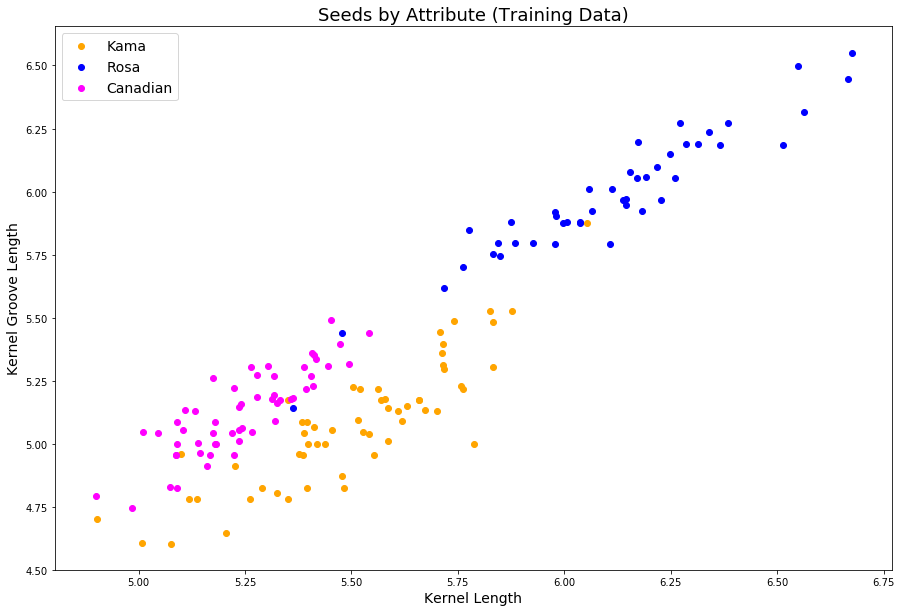

In [5]:
# Define a color map for the seed labels
colors = ['orange', 'blue', 'magenta']

# Define the label names
seeds = ['Kama', 'Rosa', 'Canadian']

# Plot each of the three groups of data
f, ax = plt.subplots(1)
for label in [1, 2, 3]:
    mask = seed_data['label'] == label
    plt.scatter(train_data['length'][mask], train_data['groove_len'][mask], label=seeds[label-1], color=colors[label-1])

# Format the plot
ax.legend(fontsize=14)
ax.set_xlabel('Kernel Length', fontsize=14)
ax.set_ylabel('Kernel Groove Length', fontsize=14)
ax.set_title('Seeds by Attribute (Training Data)', fontsize=18)

As we can see, there's already pretty good seperation of the seed classes by only these two attributes! So let's go ahead and stick to these two features alone to avoid creating an unnecessarily complex model.

In [6]:
# Drop some features
train_data = train_data.drop(labels=['area', 'perimeter', 'compactness', 'width', 'asym_coeff'], axis=1)
test_data = test_data.drop(labels=['area', 'perimeter', 'compactness', 'width', 'asym_coeff'], axis=1)
train_data.head()

,length,groove_len,label
0,5.763,5.220,1
1,5.554,4.956,1
2,5.291,4.825,1
3,5.324,4.805,1
4,5.658,5.175,1


### Gaussian Mixture Models

A Gaussian mixture model is a means of using probability to partition combined data into a number of normally distributed categories. Generally speaking, if there are multiple unique underlying sources of approximately normally distributed variance which affect the presentation of the resultant data, then a Gaussian mixture model can be used to group the data according to these sources:

![GMM image](https://upload.wikimedia.org/wikipedia/commons/7/71/Gaussian-mixture-example.svg)
Image source: https://commons.wikimedia.org/wiki/File:Gaussian-mixture-example.svg

For example, if we have a collection of human height measurements, and we know that heights are normally distributed with different means for males and females, then we might use a Gaussian mixture model to seperate the measurements by sex.

This technique is an example of **unsupervised learning**, so we don't need the label information to learn how to seperate the data into groups. Instead, we use the expectation maximization (EM) method for iteratively improving our model. First, the model is initialized with a pre-defined number of Gaussians, each with random parameters (i.e. mean and variance). Next, we calculate the expectation for each data point for each Gaussian (the "expectation" step). Then, we update the model parameters- the means, variances, and mixing coefficients for each Gaussian- to maximize these expectations (the "maximization" step). We continue iteratively performing the expectation and maximization steps until our model converges:

![EM animation](https://upload.wikimedia.org/wikipedia/commons/6/69/EM_Clustering_of_Old_Faithful_data.gif)
Animation source: https://commons.wikimedia.org/wiki/File:EM_Clustering_of_Old_Faithful_data.gif 

Let's start by training up a Gaussian mixture model for our data using scikit-learn. We'll use three Gaussians, since we know in advance that we have 3 classes in our data.

In [7]:
# Define an sk-learn mixture model
gmm = mixture.GaussianMixture(n_components=3)
# Train the model (slice out the label data!)
gmm.fit(train_data.values[:, :2])

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

Now that we have our model trained, let's see how well it predicts the seed type of our test data!

In [8]:
# Split the test data into x (feature values) and y (labels)
test_x = test_data.values[:, :2]
test_y = test_data.values[:, 2]

# Query the model for each individual data point- add 1 to the class output since original data is 1-indexed
predictions = gmm.predict(test_x) + 1

# Check the number of incorrect predictions
incorrect = len(np.where(test_y != predictions)[0])

# Calculate the test accuracy
test_acc = 100 * (len(test_y) - incorrect) / len(test_y)

print('Test accuracy is {0:.1f}%.'.format(test_acc))

Test accuracy is 98.1%.


Pretty fantastic! Particularly given that we did not provide the mixture model with any information about which training data belonged to which class.

Next, let's take a look at how our Gaussians are shaped!

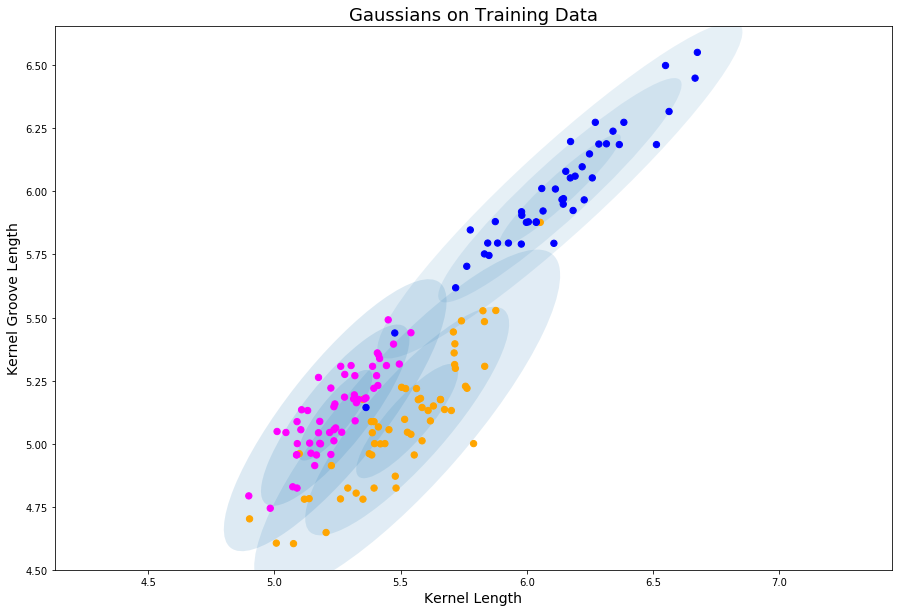

In [9]:
# This code adapted from https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html
from matplotlib.patches import Ellipse
from matplotlib import colors as mplcolors

def draw_ellipse(position, covariance, ax=None, **kwargs):
    # Set the axis
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = train_data.values[:, 2]
    if label:
        cmap = mplcolors.ListedColormap(colors)
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap=cmap, zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    # Format the plot
    ax.set_xlabel('Kernel Length', fontsize=14)
    ax.set_ylabel('Kernel Groove Length', fontsize=14)
    ax.set_title('Gaussians on Training Data', fontsize=18)
    
    w_factor = 0.15 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)
        
plot_gmm(gmm, train_data.values[:, :2])

And that's it! We've successfully used a Gaussian mixture model to seperate our data into three clusters. With this model, we can predict the seed type of any new observations using only the length of the seed kernel and the length of the groove on the kernel.

Pretty cool! Sure is great living in the future, eh?